In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from importlib import reload
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformerDropout import *


In [3]:
torch.manual_seed(305)
device = 'cuda'

SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

vocab_size = 2000

In [4]:
input_file_path = 'data/full_shakespeare.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 4,573,338


In [5]:
# Define a BPE model
tokenizer = Tokenizer(models.BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)
tokenizer.decoder = decoders.ByteLevel()

# Trainer with desired vocab size
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<unk>"])
# data should be an iterator over your text lines or documents
tokenizer.train_from_iterator([data], trainer=trainer)

# Encode and decode functions
def encode_bpe(text):
    return tokenizer.encode(text).ids

def decode_bpe(ids):
    return tokenizer.decode(ids)

# Example usage:
train_text = data[:int(len(data) * 0.9)]
val_text = data[int(len(data) * 0.9):]

train_tokens = encode_bpe(train_text)
val_tokens = encode_bpe(val_text)

import torch
train_data = torch.tensor(train_tokens)
val_data = torch.tensor(val_tokens)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")




train has 1,478,711 tokens
val has 163,429 tokens


In [6]:
# Count occurrences of each token in BPE vocabulary
token_counts = {}
for token_id in train_data:
    token_id = token_id.item()
    token_counts[token_id] = token_counts.get(token_id, 0) + 1

# Check how many tokens have at least 100 examples
tokens_with_sufficient_examples = sum(1 for count in token_counts.values() if count >= 100)
percentage = tokens_with_sufficient_examples / len(token_counts) * 100

print(f"Total unique tokens: {len(token_counts)}")
print(f"Tokens with ≥100 examples: {tokens_with_sufficient_examples} ({percentage:.2f}%)")


Total unique tokens: 1958
Tokens with ≥100 examples: 1761 (89.94%)


In [17]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device, use_focal_loss=False):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses_by_type = {
            'ce_loss': torch.zeros(eval_iters),
        }
        if use_focal_loss:
            losses_by_type['f_loss'] = torch.zeros(eval_iters)

        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, ce_loss, f_loss = model(X, Y)
            losses_by_type['ce_loss'][k] = ce_loss.item()
            if use_focal_loss:
                losses_by_type['f_loss'][k] = f_loss.item()

        out[split] = {'ce_loss': losses_by_type['ce_loss'].mean().item()}
        if use_focal_loss:
            out[split]['f_loss'] = losses_by_type['f_loss'].mean().item()

    return out

In [18]:
# Load DeepSeek as reference model
def load_deepseek_reference():
    print("Loading DeepSeek reference model...")
    model_name = "deepseek-ai/deepseek-llm-7b-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
    model.eval()
    return model, tokenizer

In [19]:
# Calculate log probability of a text sequence under DeepSeek
def calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text):
    """
    Calculate the log probability of a text sequence under DeepSeek
    """
    inputs = deepseek_tokenizer(text, return_tensors="pt").to(device)

    with torch.no_grad():
        # Get the target ids (shifted by 1 position)
        input_ids = inputs.input_ids
        target_ids = input_ids.clone()

        # Forward pass
        outputs = deepseek_model(input_ids, labels=target_ids)

    # Get the loss (negative log likelihood)
    neg_log_likelihood = outputs.loss.item()

    # Convert to log probability and normalize by sequence length
    log_prob = -neg_log_likelihood
    normalized_log_prob = log_prob / len(input_ids[0])

    return normalized_log_prob


In [20]:
# Generate text from Shakespeare model
def generate_shakespeare_text(model, prompt, max_tokens=100, temperature=1.0):
    """
    Generate text from a Shakespeare language model
    """
    model.eval()
    with torch.no_grad():
        token_ids = prompt.clone()

        for _ in range(max_tokens):
            if token_ids.size(1) > CONTEXT_WINDOW_SIZE:
                token_ids = token_ids[:, -CONTEXT_WINDOW_SIZE:]

            # Get predictions
            logits, _, _ = model(token_ids)
            logits = logits[:, -1, :] / temperature

            # Sample from the distribution
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to the sequence
            token_ids = torch.cat([token_ids, next_token], dim=1)

        return token_ids


In [21]:
# Compare two Shakespeare models using DeepSeek as reference
def compare_models_with_deepseek(model_a, model_b, deepseek_model, deepseek_tokenizer,
                              prompts, decode_fn, max_tokens=100, num_samples=5):
    """
    Compare two Shakespeare models using DeepSeek as reference

    Args:
        model_a: First Shakespeare model
        model_b: Second Shakespeare model
        deepseek_model: DeepSeek reference model
        deepseek_tokenizer: DeepSeek tokenizer
        prompts: List of prompts to use for generation
        decode_fn: Function to decode token IDs to text
        max_tokens: Maximum tokens to generate per sample
        num_samples: Number of samples to generate per prompt

    Returns:
        results: Dictionary of comparison results
    """
    results = {
        'model_a': {
            'samples': [],
            'texts': [],
            'log_probs': [],
            'perplexities': []
        },
        'model_b': {
            'samples': [],
            'texts': [],
            'log_probs': [],
            'perplexities': []
        }
    }

    for prompt in tqdm(prompts, desc="Evaluating prompts"):
        for _ in range(num_samples):
            # Generate samples from both models
            sample_a = generate_shakespeare_text(model_a, prompt, max_tokens)
            sample_b = generate_shakespeare_text(model_b, prompt, max_tokens)

            # Decode to text
            text_a = decode_fn(sample_a[0].tolist())
            text_b = decode_fn(sample_b[0].tolist())

            # Calculate log probabilities under DeepSeek
            log_prob_a = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_a)
            log_prob_b = calculate_deepseek_log_prob(deepseek_model, deepseek_tokenizer, text_b)

            # Calculate perplexity (lower is better)
            perplexity_a = np.exp(-log_prob_a)
            perplexity_b = np.exp(-log_prob_b)

            # Store results
            results['model_a']['samples'].append(sample_a)
            results['model_a']['texts'].append(text_a)
            results['model_a']['log_probs'].append(log_prob_a)
            results['model_a']['perplexities'].append(perplexity_a)

            results['model_b']['samples'].append(sample_b)
            results['model_b']['texts'].append(text_b)
            results['model_b']['log_probs'].append(log_prob_b)
            results['model_b']['perplexities'].append(perplexity_b)

    # Calculate average metrics
    results['model_a']['avg_log_prob'] = np.mean(results['model_a']['log_probs'])
    results['model_a']['avg_perplexity'] = np.mean(results['model_a']['perplexities'])
    results['model_b']['avg_log_prob'] = np.mean(results['model_b']['log_probs'])
    results['model_b']['avg_perplexity'] = np.mean(results['model_b']['perplexities'])

    return results


In [22]:
# Visualize comparison results
def visualize_comparison(results, model_a_name="Model A", model_b_name="Model B"):
    """
    Visualize the comparison results between two models
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot log probabilities
    ax1.bar([model_a_name, model_b_name],
            [results['model_a']['avg_log_prob'], results['model_b']['avg_log_prob']])
    ax1.set_title('Average Log Probability (higher is better)')
    ax1.set_ylabel('Log Probability')

    # Plot perplexities
    ax2.bar([model_a_name, model_b_name],
            [results['model_a']['avg_perplexity'], results['model_b']['avg_perplexity']])
    ax2.set_title('Average Perplexity (lower is better)')
    ax2.set_ylabel('Perplexity')

    plt.tight_layout()
    plt.show()


In [23]:
# Print sample comparisons
def print_sample_comparisons(results, num_samples=3):
    """
    Print sample text generations from both models with their metrics
    """
    print(f"{'='*20} SAMPLE COMPARISONS {'='*20}")

    for i in range(min(num_samples, len(results['model_a']['samples']))):
        print(f"\nSample {i+1}:")

        # Model A
        text_a = results['model_a']['texts'][i]
        log_prob_a = results['model_a']['log_probs'][i]
        perplexity_a = results['model_a']['perplexities'][i]

        print(f"\nModel A (Log Prob: {log_prob_a:.4f}, Perplexity: {perplexity_a:.4f}):")
        print(text_a[:500] + "..." if len(text_a) > 500 else text_a)

        # Model B
        text_b = results['model_b']['texts'][i]
        log_prob_b = results['model_b']['log_probs'][i]
        perplexity_b = results['model_b']['perplexities'][i]

        print(f"\nModel B (Log Prob: {log_prob_b:.4f}, Perplexity: {perplexity_b:.4f}):")
        print(text_b[:500] + "..." if len(text_b) > 500 else text_b)

        print(f"\n{'='*50}")


In [24]:
# Main function to run the comparison
def run_shakespeare_model_comparison(model_a, model_b, decode_bpe, prompts):
    """
    Run the full comparison between two Shakespeare models
    """
    # Load DeepSeek reference model
    deepseek_model, deepseek_tokenizer = load_deepseek_reference()
    deepseek_model = deepseek_model.to(device)

    # Compare models
    results = compare_models_with_deepseek(
        model_a,
        model_b,
        deepseek_model,
        deepseek_tokenizer,
        prompts,
        decode_bpe,
        max_tokens=100,
        num_samples=3
    )

    # Visualize results
    visualize_comparison(results, "Cross-Entropy Model", "Focal Loss Model")

    # Print sample comparisons
    print_sample_comparisons(results, num_samples=2)

    return results


In [27]:
# Helper function to train models
def train_model(model, optimizer, loss_fn="ce_loss", epochs=10):
    """
    Train a model for a specified number of epochs.

    Args:
        model: The model to train
        optimizer: The optimizer to use
        loss_fn: Which loss function to use ("ce_loss" or "focal_loss")
        epochs: Number of epochs to train for
    """
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 100  # Number of batches per epoch

        for _ in range(num_batches):
            # Get batch
            xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device, batch_size=64)

            # Forward pass
            logits, ce_loss, f_loss = model(xb, yb)

            # Use specified loss
            loss = ce_loss if loss_fn == "ce_loss" else f_loss

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print progress
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 6.1775
Epoch 2/10, Loss: 5.3978
Epoch 3/10, Loss: 5.0029
Epoch 4/10, Loss: 4.8078
Epoch 5/10, Loss: 4.6263
Epoch 6/10, Loss: 4.4607
Epoch 7/10, Loss: 4.3416
Epoch 8/10, Loss: 4.2174
Epoch 9/10, Loss: 4.1109
Epoch 10/10, Loss: 4.0138
Epoch 1/10, Loss: 6.1869
Epoch 2/10, Loss: 5.5031
Epoch 3/10, Loss: 5.0800
Epoch 4/10, Loss: 4.8906
Epoch 5/10, Loss: 4.7777
Epoch 6/10, Loss: 4.6782
Epoch 7/10, Loss: 4.5584
Epoch 8/10, Loss: 4.4619
Epoch 9/10, Loss: 4.3896
Epoch 10/10, Loss: 4.3141
Loading DeepSeek reference model...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Evaluating prompts: 100%|██████████| 2/2 [07:32<00:00, 226.47s/it]


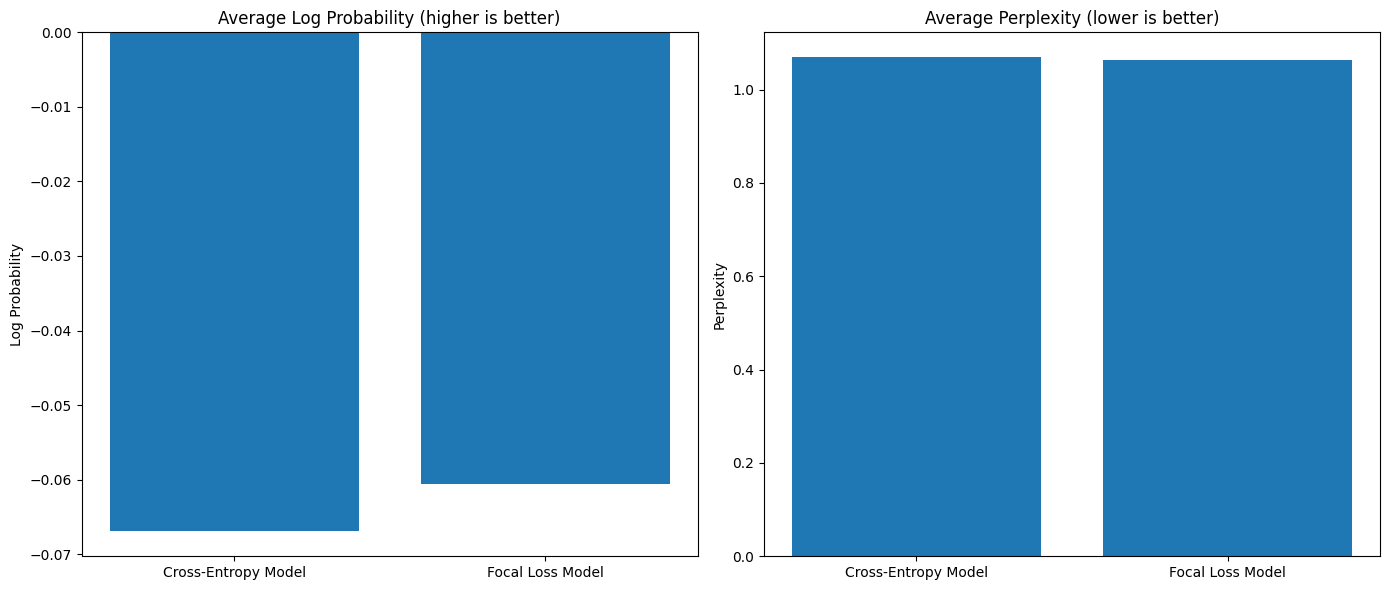

==================== SAMPLE COMPARISONS ====================

Sample 1:

Model A (Log Prob: -0.0625, Perplexity: 1.0645):
.

QUICKPRINCLA:
V cha for a mouth: 'tis it is noouse'd, well has the
verew of great by not: which those Master ither-morrow, not Jay
to all as to odgeing by you. But with Now, le then.

COSTurse:
God pro Lust laugh, tell you honour, make peed, truly he grie away: the
bege to hear himself

Model B (Log Prob: -0.0553, Perplexity: 1.0569):
 had ror,
That that is a bore but once short.

This hand?
SORD:
'Tis I cannot cere, I shall I are too.

ORLAND:
If friends, sweet master then me, I dare make us, hold,
To be swin to strivesel. Therefore, ho! my two stre thank him;
That which was so much dear Hied o'er of this
So hast us for who


Sample 2:

Model A (Log Prob: -0.0677, Perplexity: 1.0700):
ROSALIND:Alas! Sir Swear!
for I make your conecatch, sweet a good ; you in your
un till the feet come. Come, no that you that will not
solurself you come upon your offic subjects, 

In [47]:
# Create two models with different configurations
model_ce = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE, dropout=0).to(device)
model_focal = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE, dropout=0.1).to(device)

# Train models with different loss functions
train_model(model_ce, optim.Adam(model_ce.parameters(), lr=1e-4), loss_fn="ce_loss", epochs=10)
train_model(model_focal, optim.Adam(model_focal.parameters(), lr=1e-4), loss_fn="focal_loss", epochs=10)

# Create prompts for evaluation
prompts = [
    torch.tensor([[0]], device=device),  # Empty context
    torch.tensor([[45, 67, 89, 12, 34]], device=device),  # Custom prompt
]

# Run comparison
results = run_shakespeare_model_comparison(model_ce, model_focal, decode_bpe, prompts)